In [150]:
from numpy import interp

import pandas as pd
import matplotlib.pyplot as plt 
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [151]:
from pprint import pprint
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc

### Creating Dataframe

In [250]:
comp = pd.read_csv('C:/Users/daswa/Desktop/Data Science Projects/Healthcare_Startup_Assessment/data_store/processed/final_data_companies_social_media.csv')
comp = comp[comp.stage.notna() 
     & comp.name.notna() & comp["size_numeric"].notna()]
comp['market'] = comp['market'].apply(lambda row: str(row).replace(" ", "_"))

In [265]:
comp['raised_2mil_new'] = comp['raised'].apply(lambda row: 1 if row>1000000 else 0)

In [266]:
comp.head()

,joined,kind,link,location,market,name,Unnamed: 6,raised,size,stage,website,years,annual_raised,raised_2mil,raised_12mil,size_numeric,followers,following,raised_2mil_new
0,5/1/2012,Startup,https://angel.co/company/ginx,Las Vegas,Mobile_Commerce,*Ginx,NaN,700000,10-Jan,Seed,ginxapp.com,7.627397,9.177443e+04,0,0,5.0,57,74,0
1,10/1/2012,Startup,https://angel.co/company/1world-1,Redwood City,Polling,1World Online,NaN,7280000,10-Jan,Series A,1worldonline.com,7.208219,1.009958e+06,1,0,5.0,5643,1427,1
2,8/1/2014,Startup,https://angel.co/company/21,San Francisco,Bitcoin,21,NaN,116000000,Nov-50,Seed,21.co,5.375342,2.158002e+07,1,1,25.0,0,0,1
3,9/1/2013,Startup,https://angel.co/company/24sessions,Amsterdam,Developer_APIs,24sessions,NaN,135000,Nov-50,Seed,24sessions.com,6.290411,2.146124e+04,0,0,25.0,2657,3032,0
4,2/1/2016,Startup,https://angel.co/company/2morrow,Seattle,B2B,2Morrow,NaN,350000,Nov-50,Seed,2morrowinc.com,3.871233,9.041047e+04,0,0,25.0,1244,916,0


### One hot encoding

In [267]:
seed = comp[(comp["stage"]=="Seed")]
seed_y = seed['raised_2mil']


In [254]:
seed.shape

(1912, 19)

In [255]:
seed.columns

Index(['joined', 'kind', 'link', 'location', 'market', 'name', 'Unnamed: 6',
       'raised', 'size', 'stage', 'website', 'years', 'annual_raised',
       'raised_2mil', 'raised_12mil', 'size_numeric', 'followers', 'following',
       'raised_2mil_new'],
      dtype='object')

In [101]:
comp.shape

(2446, 19)

In [256]:
seriesA = comp[(comp["stage"]=="Series A")]
seriesA_y = seriesA['raised_12mil']

In [268]:
def one_hot(dataframe, nominal):
    gen_onehot_features = pd.get_dummies(dataframe[nominal])
    result = pd.concat([dataframe, gen_onehot_features],axis=1)
    result.drop([nominal],axis=1,inplace=True)
    result.drop(result.columns[(result == 0).sum() > 0.995*result.shape[0]], axis = 1, inplace = True) 

    return result

In [269]:
def one_hot_market(dataframe):
    gen_onehot_features = pd.get_dummies(dataframe['market'])
    result = pd.concat([dataframe, gen_onehot_features],axis=1)
    result.drop(['market'],axis=1,inplace=True)
#     print(result.columns[(result == 0).sum() > 0.995*result.shape[0]])
    result.drop(result.columns[(result == 0).sum() > 0.995*result.shape[0]], axis = 1, inplace = True) 

    return result

def one_hot_location(dataframe):
    gen_onehot_features = pd.get_dummies(dataframe['location'])
    result = pd.concat([dataframe, gen_onehot_features],axis=1)
    result.drop(['location'],axis=1,inplace=True)
    result.drop(result.columns[(result == 0).sum() > 0.995*result.shape[0]], axis = 1, inplace = True) 

    return result

In [270]:
seriesA['size'].value_counts()

Nov-50       285
51-200       136
10-Jan        94
201-500       15
501-1000       3
1001-5000      1
Name: size, dtype: int64

In [271]:
comp['stage'].value_counts()

Seed        1912
Series A     534
Name: stage, dtype: int64

### Data for modeling

In [319]:
seed_x =one_hot(one_hot(seed[['location','size_numeric','followers','years','market']],"location"),"market")


In [273]:
#seed_x['followers'] = seed['followers']

In [274]:
seed_x.head()

,size_numeric,years,Amsterdam,Atlanta,Austin,Bengaluru,Berlin,Boulder,Buenos Aires Province,Cambridge,...,Productivity_Software,Retail_Technology,SaaS,Small_and_Medium_Businesses,Social_Media,Social_Media_Platforms,Technology,Training,Video_Streaming,nan
0,5.0,7.627397,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,25.0,5.375342,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,25.0,6.290411,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,25.0,3.871233,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5.0,7.290411,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [202]:
seed_final_all_features = seed_x 
seed_final_all_features['raised_2m'] = seed_y.to_frame()
seed_final_all_features.to_csv('../data_store/processed/seed_final_all_features.csv')   

In [203]:
seed_x.shape

(1912, 84)

In [364]:
seriesA_x =one_hot(one_hot(seriesA[['location','size_numeric','followers','years','market']],"location"),"market")
#seriesA_x['followers'] = seriesA['followers']

In [365]:
for i in [seed_x, seed_y, seriesA_x, seriesA_y]:
    print(i.shape)

(1912, 84)
(1912,)
(534, 97)
(534,)


In [135]:
seriesA_final_all_features = seriesA_x 
seriesA_final_all_features['raised_2m'] = seriesA_y.to_frame()
seriesA_final_all_features.to_csv('../data_store/processed/seriesA_final_all_features.csv')   

In [277]:
rs = 1

In [320]:
seed_x_train, seed_x_test, seed_y_train, seed_y_test = train_test_split(seed_x, 
                                                                        seed_y, 
                                                                        test_size=0.2,
                                                                        random_state=rs)

In [366]:
seriesA_x_train, seriesA_x_test, seriesA_y_train, seriesA_y_test = train_test_split(seriesA_x, 
                                                                                    seriesA_y, 
                                                                                    test_size=0.2, 
                                                                                    random_state=rs)

In [280]:
def split_downsample(X,y):
    var= y.name
    #split data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33)
    #combine them back for resampling
    train_data = pd.concat([X_train, y_train], axis=1)
    # separate minority and majority classes
    negative = train_data[train_data[var]==0]
    positive = train_data[train_data[var]==1]

    # downsample majority
    neg_downsampled = resample(negative,
        replace=True, # sample with replacement
        n_samples=len(positive), # match number in minority class
        ) # reproducible results
    
    
    # combine majority and upsampled minority
    upsampled = pd.concat([neg_downsampled, positive])
    # check new class counts
    
    new_X_train = upsampled.drop(var,axis=1)
    new_y_train = upsampled[var]
    
    return new_X_train, X_test, new_y_train, y_test

In [281]:
def downsample(X,y,rs=None):
    var= y.name
    
    joint = pd.concat([X, y], axis=1)
    negative = joint[joint[var]==0]
    positive = joint[joint[var]==1]

    # downsample majority
    neg_downsampled = resample(negative,
        replace=True, # sample with replacement
        n_samples=len(positive), # match number in minority class
        random_state = rs) # reproducible results
    
    
    # combine majority and upsampled minority
    upsampled = pd.concat([neg_downsampled, positive])
    # check new class counts
    
    new_X = upsampled.drop(var,axis=1)
    new_y = upsampled[var]
    
    return new_X, new_y

In [212]:
downsample(seed_x_train, seed_y_train)[1].value_counts()

1    474
0    474
Name: raised_2mil_new, dtype: int64

In [213]:
def downsample_split(X,y):
    var= y.name
    #combine them for resampling
    train_data = pd.concat([X, y], axis=1)
    # separate minority and majority classes
    negative = train_data[train_data[var]==0]
    positive = train_data[train_data[var]==1]

    # downsample majority
    neg_downsampled = resample(negative,
        replace=True, # sample with replacement
        n_samples=len(positive), # match number in minority class
        ) # reproducible results
    
    
    # combine majority and upsampled minority
    upsampled = pd.concat([neg_downsampled, positive])
    
    X_train, X_test, y_train, y_test = train_test_split( 
        upsampled.drop(var,axis=1), upsampled[var], stratify=upsampled[var],
        test_size=0.33,)
    
    # check new class counts
#     print(y_train.value_counts())

    return X_train, X_test, y_train, y_test

### Training Set variable selection (Logistic Regression p-value)

In [367]:
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif, SelectKBest

In [368]:
def get_feat(method, k, x, y):
    select = SelectKBest(method, k)
    _ = select.fit_transform(x, y)
    return [x.columns[i] for i, val in enumerate(select.get_support()) if val]

In [369]:
num_features = 10

#### seed

In [324]:
mutual_seed = get_feat(mutual_info_classif, num_features, seed_x_train, seed_y_train)

In [325]:
chi2_seed = get_feat(chi2, num_features, seed_x_train, seed_y_train)

In [326]:
f_seed = get_feat(f_classif, num_features, seed_x_train, seed_y_train)

In [327]:
chi2_seed

['size_numeric',
 'followers',
 'years',
 'Austin',
 'San Francisco',
 'Seattle',
 'Big_Data_Analytics',
 'Health_Care_Information_Technology',
 'Mobile_Games',
 'Predictive_Analytics']

In [328]:
f_seed

['size_numeric',
 'followers',
 'years',
 'Austin',
 'San Francisco',
 'Seattle',
 'Crowdsourcing',
 'Health_Care_Information_Technology',
 'Mobile_Games',
 'Predictive_Analytics']

In [329]:
mutual_seed

['size_numeric',
 'followers',
 'years',
 'Las Vegas',
 'New York City',
 'Silicon Valley',
 'Sunnyvale',
 'Internet_of_Things',
 'Mobile_Advertising',
 'Productivity_Software']

#### Series A

In [370]:
mutual_seriesA = get_feat(mutual_info_classif, num_features, seriesA_x_train, seriesA_y_train)

In [371]:
chi2_seriesA = get_feat(chi2, num_features, seriesA_x_train, seriesA_y_train)

In [372]:
f_seriesA = get_feat(f_classif, num_features, seriesA_x_train, seriesA_y_train)

In [373]:
f_seriesA

['size_numeric',
 'years',
 'San Mateo',
 'Sydney',
 'Washington DC',
 'Application_Platforms',
 'Banking',
 'Cloud_Infrastructure',
 'Consumer_Electronics',
 'Investment_Management']

In [374]:
chi2_seriesA

['size_numeric',
 'followers',
 'years',
 'San Mateo',
 'Washington DC',
 'Application_Platforms',
 'Banking',
 'Cloud_Infrastructure',
 'Consumer_Electronics',
 'Investment_Management']

In [375]:
mutual_seriesA

['size_numeric',
 'years',
 'Boston',
 'Crowdsourcing',
 'Data_Integration',
 'Investment_Management',
 'K-12_Education',
 'Location_Based_Services',
 'Mobile_Payments',
 'Online_Reservations']

In [336]:
import statsmodels.api as sm
import numpy as np

def logiVarSelect(x, y, sig_lvl, columns):
    while True:
        logi = sm.Logit(y, x).fit(method='bfgs',maxiter=1000) # The maxiter is increased to help convergence for seed
        maxP = max(logi.pvalues)
        if maxP > sig_lvl:
            loc = list(logi.pvalues).index(maxP)
            x = np.delete(x, loc, 1)
            columns = np.delete(columns, loc)
        else: 
            return columns

In [376]:
selected_columns_seed = seed_x_train.columns.values
selected_columns_seriesA = seriesA_x_train.columns.values

SL = 0.05

In [377]:
selected_columns_seed

array(['size_numeric', 'followers', 'years', 'Amsterdam', 'Atlanta',
       'Austin', 'Bengaluru', 'Berlin', 'Boulder',
       'Buenos Aires Province', 'Cambridge', 'Chicago', 'Cleveland',
       'Dallas', 'Delhi', 'Las Vegas', 'London', 'Los Angeles', 'Miami',
       'Montreal', 'Mountain View', 'New York City', 'Palo Alto', 'Paris',
       'Philadelphia', 'Portland', 'San Diego', 'San Francisco',
       'San Jose', 'San Mateo', 'Santa Monica', 'Santiago', 'Seattle',
       'Silicon Valley', 'Singapore', 'Sunnyvale', 'Sydney',
       'Tel Aviv-Yafo', 'Toronto', 'Vancouver', 'Washington DC',
       'Advertising_Platforms', 'B2B', 'Big_Data', 'Big_Data_Analytics',
       'Consumer_Electronics', 'Corporate_Wellness', 'Crowdsourcing',
       'Developer_APIs', 'Education', 'Enterprise_Security', 'Events',
       'Fantasy_Sports', 'Finance_Technology', 'Fitness',
       'Health_Care_Information_Technology', 'Hospitality',
       'Human_Resources', 'Internet_of_Things', 'K-12_Education', 'Ki

In [339]:
p_seed = logiVarSelect(seed_x_train.values, seed_y_train.values, SL, selected_columns_seed)

C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: Runti

         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 16
         Gradient evaluations: 4
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.410322
         Iterations: 210
         Function evaluations: 213
         Gradient evaluations: 213
Optimization terminated successfully.
         Current function value: 0.410322
         Iterations: 210
         Function evaluations: 213
         Gradient evaluations: 213
Optimization terminated successfully.
         Current function value: 0.412979
         Iterations: 208
         Function evaluations: 211
         Gradient evaluations: 211
Optimization terminated successfully.
         Current function value: 0.414771
         Iterations: 207
         Function evaluations: 210
         Gradient evaluations: 210
Optimization terminated successfully

Optimization terminated successfully.
         Current function value: 0.422352
         Iterations: 119
         Function evaluations: 122
         Gradient evaluations: 122
Optimization terminated successfully.
         Current function value: 0.422520
         Iterations: 119
         Function evaluations: 122
         Gradient evaluations: 122
Optimization terminated successfully.
         Current function value: 0.422709
         Iterations: 119
         Function evaluations: 122
         Gradient evaluations: 122
Optimization terminated successfully.
         Current function value: 0.422956
         Iterations: 120
         Function evaluations: 123
         Gradient evaluations: 123
Optimization terminated successfully.
         Current function value: 0.423219
         Iterations: 120
         Function evaluations: 123
         Gradient evaluations: 123
Optimization terminated successfully.
         Current function value: 0.423496
         Iterations: 120
         Function ev

In [340]:
p_seed

array(['years', 'Austin', 'London', 'New York City', 'San Francisco',
       'Seattle', 'Big_Data_Analytics', 'Mobile_Games'], dtype=object)

In [378]:
p_seriesA = logiVarSelect(seriesA_x_train.values, seriesA_y_train.values, SL, selected_columns_seriesA)

C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: Runti

         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 16
         Gradient evaluations: 4
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.434395
         Iterations: 273
         Function evaluations: 275
         Gradient evaluations: 275
Optimization terminated successfully.
         Current function value: 0.436981
         Iterations: 273
         Function evaluations: 275
         Gradient evaluations: 275
Optimization terminated successfully.
         Current function value: 0.441441
         Iterations: 268
         Function evaluations: 270
         Gradient evaluations: 270
Optimization terminated successfully.
         Current function value: 0.445013
         Iterations: 252
         Function evaluations: 254
         Gradient evaluations: 254
Optimization terminated successfully

Optimization terminated successfully.
         Current function value: 0.516498
         Iterations: 126
         Function evaluations: 128
         Gradient evaluations: 128
Optimization terminated successfully.
         Current function value: 0.516621
         Iterations: 126
         Function evaluations: 128
         Gradient evaluations: 128
Optimization terminated successfully.
         Current function value: 0.516772
         Iterations: 126
         Function evaluations: 128
         Gradient evaluations: 128
Optimization terminated successfully.
         Current function value: 0.516971
         Iterations: 123
         Function evaluations: 125
         Gradient evaluations: 125
Optimization terminated successfully.
         Current function value: 0.517167
         Iterations: 123
         Function evaluations: 125
         Gradient evaluations: 125
Optimization terminated successfully.
         Current function value: 0.517432
         Iterations: 124
         Function ev

In [379]:
p_seriesA

array(['years'], dtype=object)

In [380]:
pd.set_option('display.max_colwidth', None)

data = [
['P-value', p_seed],
['Chi Squared/F-value', chi2_seed],
['Mutual information', mutual_seed],
]
df = pd.DataFrame(data, columns = ['Selection Method', 'Seed Selected Variables']) 
df

,Selection Method,Seed Selected Variables
0,P-value,"[years, Austin, London, New York City, San Francisco, Seattle, Big_Data_Analytics, Mobile_Games]"
1,Chi Squared/F-value,"[size_numeric, followers, years, Austin, San Francisco, Seattle, Big_Data_Analytics, Health_Care_Information_Technology, Mobile_Games, Predictive_Analytics]"
2,Mutual information,"[size_numeric, followers, years, Las Vegas, New York City, Silicon Valley, Sunnyvale, Internet_of_Things, Mobile_Advertising, Productivity_Software]"


In [305]:
type(seed_x)

pandas.core.frame.DataFrame

In [183]:
seed_final = seed_x[chi2_seed]
seed_final['raised_2m'] = seed_y.to_frame()
seed_final.head()

C:\Users\daswa\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,size_numeric,followers,Montreal,New York City,San Francisco,Seattle,Crowdsourcing,Health_Care_Information_Technology,Medical_Devices,Mobile_Games,raised_2m
0,5.0,57,0,0,0,0,0,0,0,0,0
2,25.0,0,0,0,1,0,0,0,0,0,1
3,25.0,2657,0,0,0,0,0,0,0,0,0
4,25.0,1244,0,0,0,1,0,0,0,0,0
5,5.0,327,0,0,0,0,0,0,0,0,0


In [184]:
seed_final.to_csv('../data_store/processed/seed_final.csv')   

In [381]:
data = [['P-value', p_seriesA],
['Chi Squared/F-value', chi2_seriesA],
['Mutual information', mutual_seriesA],
]
df = pd.DataFrame(data, columns = ['Selection Method', 'SeriesA Selected Variables']) 
df

,Selection Method,SeriesA Selected Variables
0,P-value,[years]
1,Chi Squared/F-value,"[size_numeric, followers, years, San Mateo, Washington DC, Application_Platforms, Banking, Cloud_Infrastructure, Consumer_Electronics, Investment_Management]"
2,Mutual information,"[size_numeric, years, Boston, Crowdsourcing, Data_Integration, Investment_Management, K-12_Education, Location_Based_Services, Mobile_Payments, Online_Reservations]"


In [243]:
seriesA_final = seriesA_x[chi2_seriesA]
seriesA_final['raised_12m'] = seriesA_y.to_frame()
seed_final.to_csv('../data_store/processed/seriesA_final.csv')

C:\Users\daswa\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Comparing models with different feature engineering techniques

In [382]:
colors=['red','darkorange','royalblue','blueviolet']

In [383]:
def scikit_logi(X,y,samplemethod):
    # Splits x,y into testing and validation sets, and return the fpr and tpr of the validation set 
    X_train, X_test, y_train, y_test = samplemethod(X, y)
    logi = LogisticRegression(solver='lbfgs',max_iter=1000)
    model = logi.fit(X_train,y_train)
    y_pred_proba = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
    return (fpr, tpr)

In [384]:
def logi_plot_roc(x,y,c,show_detail=False,txtlabel=""):
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for i in range(100):
        fpr_R_seed_sel, tpr_R_seed_sel = scikit_logi(x,y, split_downsample)
        if show_detail == True:
            plt.plot(fpr_R_seed_sel, tpr_R_seed_sel, lw=0.1, color = c, alpha=0.6)

        interp_tpr = interp(mean_fpr, fpr_R_seed_sel, tpr_R_seed_sel)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr_R_seed_sel,tpr_R_seed_sel))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color=c,
            label=txtlabel+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
            lw=2, alpha=0.8)

    if show_detail == True:
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=.3,
                        label=r'$\pm$ 1 std. dev.')
    return(mean_fpr, mean_tpr, mean_auc, std_auc)

In [385]:
def label():
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

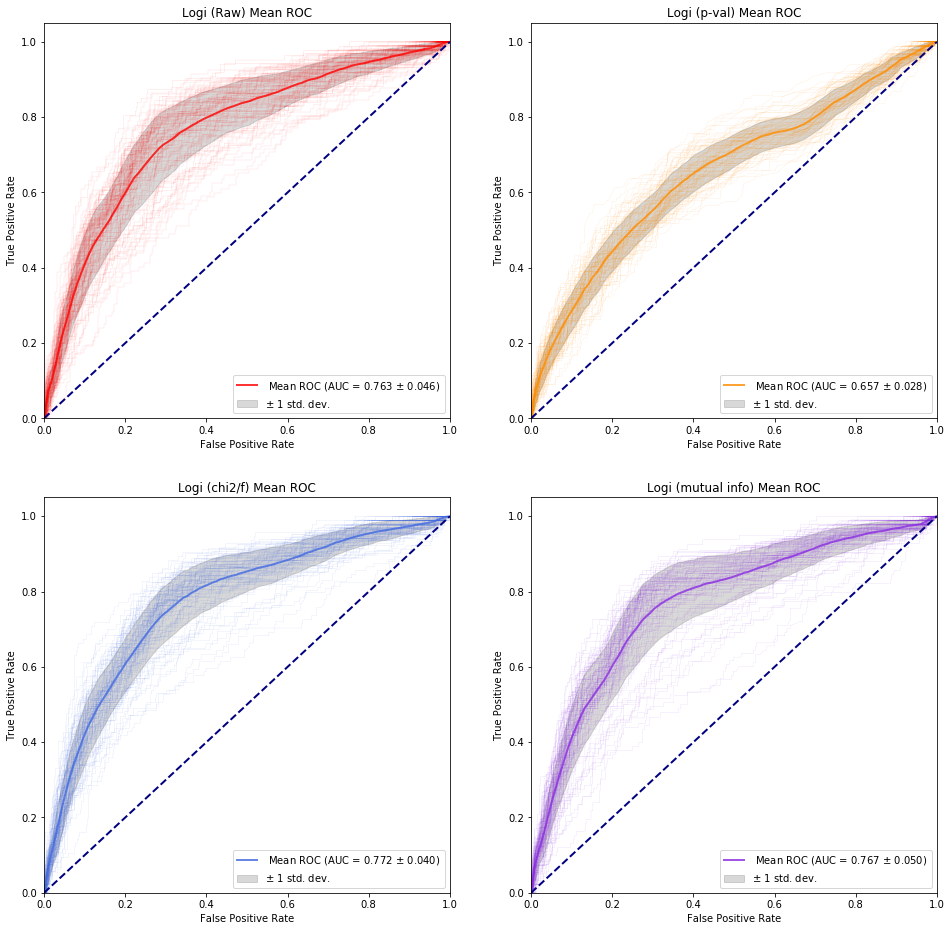

In [349]:
fig = plt.figure(figsize=(16,16))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


ax = fig.add_subplot(2, 2, 1)
c1_mean_fpr, c1_mean_tpr, c1_mean_auc, c1_std_auc = logi_plot_roc(seed_x_train,seed_y_train,colors[0],show_detail=True)
label()
plt.title("Logi (Raw) Mean ROC")

ax = fig.add_subplot(2, 2, 2)
c2_mean_fpr, c2_mean_tpr, c2_mean_auc, c2_std_auc = logi_plot_roc(seed_x_train[p_seed],seed_y_train,colors[1],show_detail=True)
label()
plt.title("Logi (p-val) Mean ROC")

ax = fig.add_subplot(2, 2, 3)
c3_mean_fpr, c3_mean_tpr, c3_mean_auc, c3_std_auc = logi_plot_roc(seed_x_train[chi2_seed],seed_y_train,colors[2],show_detail=True)
label()
plt.title("Logi (chi2/f) Mean ROC")

ax = fig.add_subplot(2, 2, 4)
c4_mean_fpr, c4_mean_tpr, c4_mean_auc, c4_std_auc = logi_plot_roc(seed_x_train[mutual_seed],seed_y_train,colors[3],show_detail=True)
label()
plt.title("Logi (mutual info) Mean ROC")
plt.savefig('seed_4x.png')


plt.show()

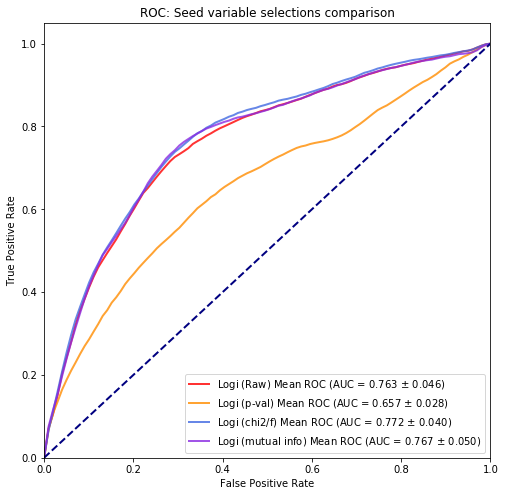

In [351]:
fig = plt.figure(figsize=(8,8))

plt.plot(c1_mean_fpr, c1_mean_tpr, color=colors[0], label="Logi (Raw)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c1_mean_auc, c1_std_auc), lw=2, alpha=0.8)
plt.plot(c2_mean_fpr, c2_mean_tpr, color=colors[1], label="Logi (p-val)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c2_mean_auc, c2_std_auc), lw=2, alpha=0.8)
plt.plot(c3_mean_fpr, c3_mean_tpr, color=colors[2], label="Logi (chi2/f)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c3_mean_auc, c3_std_auc), lw=2, alpha=0.8)
plt.plot(c4_mean_fpr, c4_mean_tpr, color=colors[3], label="Logi (mutual info)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c4_mean_auc, c4_std_auc), lw=2, alpha=0.8)

label()

plt.title("ROC: Seed variable selections comparison")
plt.savefig('seed_all.png')


plt.show()

In [352]:
def test_results(x_train, y_train, x_test, y_test):
    x_train, y_train = downsample(x_train, y_train,rs)
    logi = LogisticRegression(solver='lbfgs',max_iter=400)
    logi.fit(x_train, y_train)
    acc = logi.score(x_test, y_test)
    y_pred = logi.predict(x_test)
    cm = confusion_matrix(y_test, y_pred,labels=[1, 0])
    tpr = cm[0][0]/np.sum(cm[0])
    tnr = cm[1][1]/np.sum(cm[1])
    return(list(np.round([acc,tpr,tnr],3)))

In [353]:
test_results(seed_x_train, seed_y_train, seed_x_test, seed_y_test)

[0.76, 0.691, 0.775]

In [354]:
test_results(seed_x_train[p_seed], seed_y_train, seed_x_test[p_seed], seed_y_test)

[0.637, 0.485, 0.67]

In [355]:

test_results(seed_x_train[chi2_seed], seed_y_train, seed_x_test[chi2_seed], seed_y_test)

[0.76, 0.691, 0.775]

In [356]:
test_results(seed_x_train[mutual_seed], seed_y_train, seed_x_test[mutual_seed], seed_y_test)

[0.762, 0.721, 0.771]

In [357]:
data = [
    ["Seed Raw"] + test_results(seed_x_train, seed_y_train, seed_x_test, seed_y_test),
    ["Seed P-value"] + test_results(seed_x_train[p_seed], seed_y_train, seed_x_test[p_seed], seed_y_test),
    ["Seed Chi2/F"] + test_results(seed_x_train[chi2_seed], seed_y_train, seed_x_test[chi2_seed], seed_y_test),
    ["Seed Mutual"] + test_results(seed_x_train[mutual_seed], seed_y_train, seed_x_test[mutual_seed], seed_y_test)]
df = pd.DataFrame(data, columns = ['Method','Test Accuracy', 'TPR', "TNR"]) 
df

,Method,Test Accuracy,TPR,TNR
0,Seed Raw,0.760,0.691,0.775
1,Seed P-value,0.637,0.485,0.670
2,Seed Chi2/F,0.760,0.691,0.775
3,Seed Mutual,0.762,0.721,0.771


In [359]:
logi = sm.Logit(seed_y_train, seed_x_train[chi2_seed]).fit(method='bfgs',maxiter=1000) # The maxiter is increased to help convergence for seed

         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 16
         Gradient evaluations: 4


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [360]:
print(logi.summary())

                           Logit Regression Results                           
Dep. Variable:            raised_2mil   No. Observations:                 1529
Model:                          Logit   Df Residuals:                     1519
Method:                           MLE   Df Model:                            9
Date:                Fri, 12 Jun 2020   Pseudo R-squ.:                 -0.4742
Time:                        15:29:19   Log-Likelihood:                -1059.8
converged:                      False   LL-Null:                       -718.91
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
size_numeric                                0      0.000          0      1.000      -0.000       0.000
followers                                   0   3.03e-06   

In [90]:
seriesA.shape, seed.shape

((534, 18), (1912, 18))

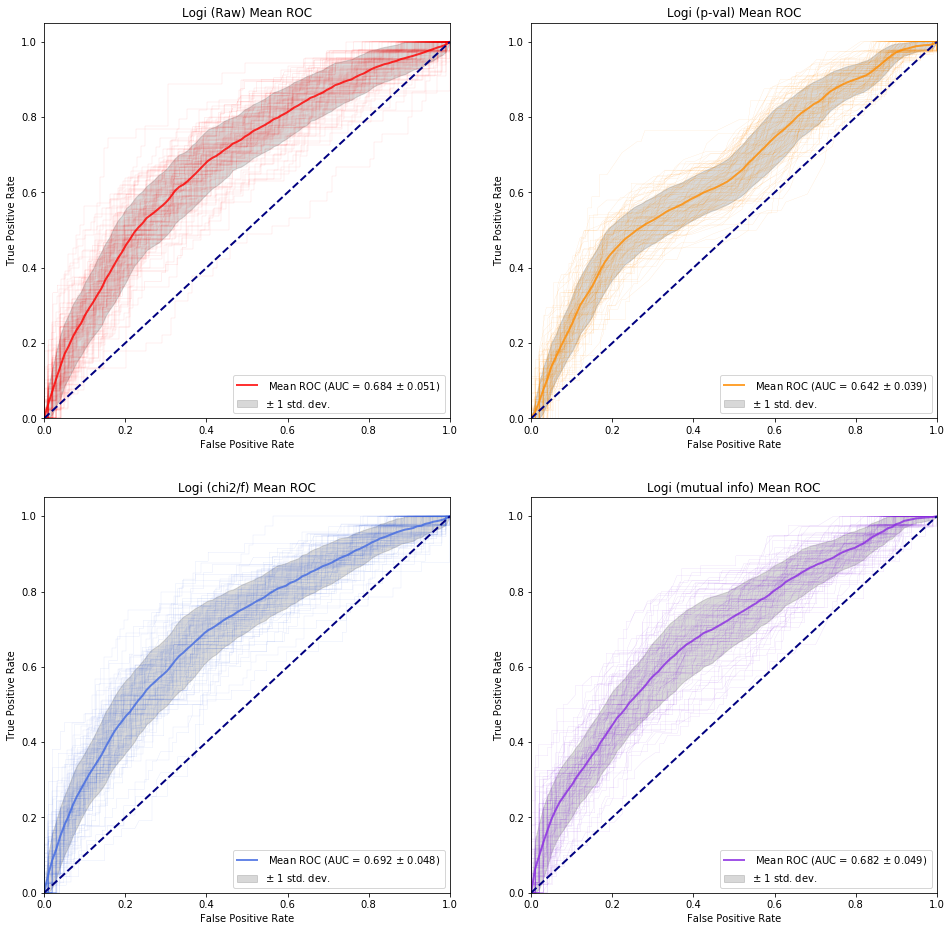

In [386]:
fig = plt.figure(figsize=(16,16))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


ax = fig.add_subplot(2, 2, 1)
c1_mean_fpr, c1_mean_tpr, c1_mean_auc, c1_std_auc = logi_plot_roc(seriesA_x_train,seriesA_y_train,colors[0],show_detail=True)
label()
plt.title("Logi (Raw) Mean ROC")

ax = fig.add_subplot(2, 2, 2)
c2_mean_fpr, c2_mean_tpr, c2_mean_auc, c2_std_auc = logi_plot_roc(seriesA_x_train[p_seriesA],seriesA_y_train,colors[1],show_detail=True)
label()
plt.title("Logi (p-val) Mean ROC")

ax = fig.add_subplot(2, 2, 3)
c3_mean_fpr, c3_mean_tpr, c3_mean_auc, c3_std_auc = logi_plot_roc(seriesA_x_train[chi2_seriesA],seriesA_y_train,colors[2],show_detail=True)
label()
plt.title("Logi (chi2/f) Mean ROC")

ax = fig.add_subplot(2, 2, 4)
c4_mean_fpr, c4_mean_tpr, c4_mean_auc, c4_std_auc = logi_plot_roc(seriesA_x_train[mutual_seriesA],seriesA_y_train,colors[3],show_detail=True)
label()
plt.title("Logi (mutual info) Mean ROC")
plt.savefig('seriesA_4x.png')

plt.show()

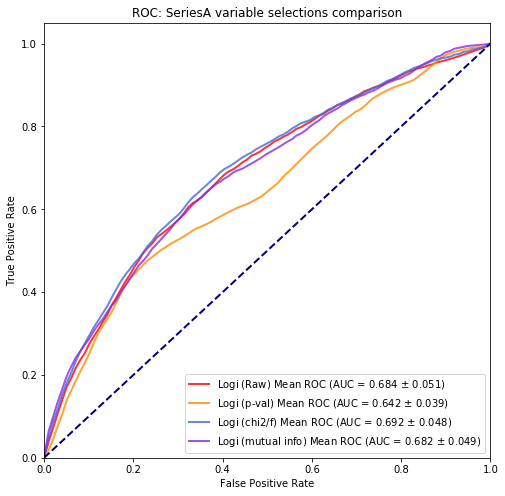

In [387]:
fig = plt.figure(figsize=(8,8))

plt.plot(c1_mean_fpr, c1_mean_tpr, color=colors[0], label="Logi (Raw)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c1_mean_auc, c1_std_auc), lw=2, alpha=0.8)
plt.plot(c2_mean_fpr, c2_mean_tpr, color=colors[1], label="Logi (p-val)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c2_mean_auc, c2_std_auc), lw=2, alpha=0.8)
plt.plot(c3_mean_fpr, c3_mean_tpr, color=colors[2], label="Logi (chi2/f)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c3_mean_auc, c3_std_auc), lw=2, alpha=0.8)
plt.plot(c4_mean_fpr, c4_mean_tpr, color=colors[3], label="Logi (mutual info)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c4_mean_auc, c4_std_auc), lw=2, alpha=0.8)

label()

plt.title("ROC: SeriesA variable selections comparison")
plt.savefig('seriesA_all.png')


plt.show()

In [388]:
data = [
    ["SeriesA Raw"] + test_results(seriesA_x_train, seriesA_y_train, seriesA_x_test, seriesA_y_test),
    ["SeriesA P-value"] + test_results(seriesA_x_train[p_seriesA], seriesA_y_train, seriesA_x_test[p_seriesA], seriesA_y_test),
    ["SeriesA Chi2/F"] + test_results(seriesA_x_train[chi2_seriesA], seriesA_y_train, seriesA_x_test[chi2_seriesA], seriesA_y_test),
    ["SeriesA Mutual"] + test_results(seriesA_x_train[mutual_seriesA], seriesA_y_train, seriesA_x_test[mutual_seriesA], seriesA_y_test)]
df = pd.DataFrame(data, columns = ['Method','Test Accuracy', 'TPR', "TNR"]) 
df

,Method,Test Accuracy,TPR,TNR
0,SeriesA Raw,0.748,0.348,0.857
1,SeriesA P-value,0.645,0.522,0.679
2,SeriesA Chi2/F,0.748,0.348,0.857
3,SeriesA Mutual,0.701,0.391,0.786


In [393]:
seed_y_train.value_counts()

0    1255
1     274
Name: raised_2mil, dtype: int64